# Semester 3 Coding Portfolio Topic 2 Formative Part 1/2:
# Natural Language Processing

This notebook covers the following topics:
 - Data cleaning
 - Sentiment analysis
 - Topic modeling

This notebook is expected to take around 5 hours to complete:
 - 2 hours for the formative part
 - 3 hours of self-study on the topics covered by this notebook

Like all topics in this portfolio, this topic is split into two sections:
 - Formative 
 - Summative

<b>Formative section</b><br>
Simply complete the given functions such that they pass the automated tests. This part is graded Pass/Fail; you must get 100% correct!
You can submit your notebook through Canvas as often as you like. Make sure to start doing so early to insure that your code passes all tests!
You may ask for help from fellow students and TAs on this section, and solutions might be provided later on.

In this workshop, we will try out different NLP methods. We will learn how to preprocess text, and how it affects the outcomes of the methods.

We will do so in party by applying NLP to a dataset of Trump Twitter messages. 

You will also get to make sure that you have all the required packages and that they run properly. You may find that some of the packages will require some fiddling, in particular visualization in Jupyter with BERTopic. 

The type of preprocessing needed varies between methods, and the preprocessing can affect the result in important and not always easily predictable ways.

We will look at different NLP tasks, such as sentiment analysis, topic modeling, and machine learning, and your task will be to find how to preprocess the data to produce the best outcomes.



In [1]:
import pandas as pd

In [4]:
#Let's load the data
df = pd.read_csv('/Users/uliwintersperger/Desktop/uni/cssci/semester-03/individual_assignments_s3/coding_portfolio/data/sem3_topic2_nlp_formative1_data1.csv')


## Overview of data

Let's start by getting a feeling for the data, through some simple descriptive statistics.

In [5]:
# Some example messages
df.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
0,98454970654916608,Republicans and Democrats have both created ou...,f,f,TweetDeck,49,255,2011-08-02 18:07:48,f
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f


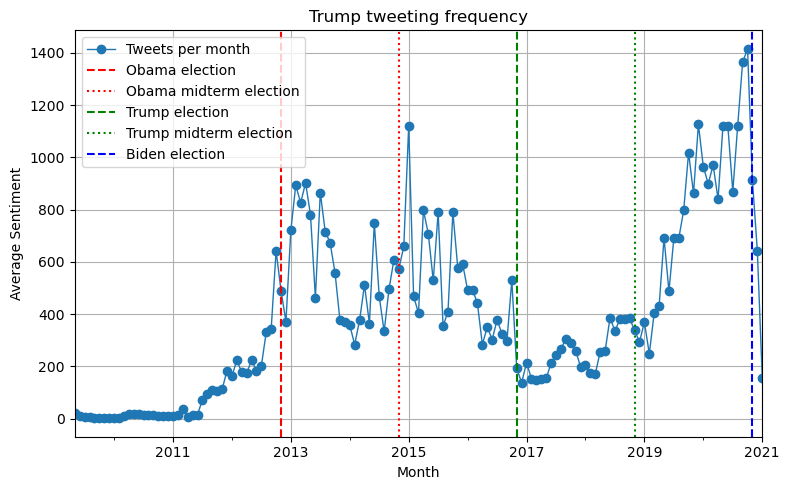

In [6]:
# Plot posting frequency over time

import matplotlib.pyplot as plt

df['month'] = df.date.str[:7]+'-01'
df['month'] = pd.to_datetime(df['month']) 
fig, ax = plt.subplots(figsize=(8,5))

# Group the posts per month, then count, and plot the result!
df.groupby(['month'])['id'].count().plot(ax=ax, marker='o', lw=1,label='Tweets per month')

# Some style
ax.set_xlabel('Month')
ax.set_ylabel('Average Sentiment')
ax.set_title("Trump tweeting frequency")

# Let's add vertical lines for the elections
ax.axvline('2012-11-06', color='red', linestyle='--',label='Obama election')
ax.axvline('2014-11-06', color='red', linestyle=':',label='Obama midterm election')
ax.axvline('2016-11-08', color='green', linestyle='--',label='Trump election')
ax.axvline('2018-11-06', color='green', linestyle=':',label='Trump midterm election')
ax.axvline('2020-11-03', color='blue', linestyle='--',label='Biden election')

ax.grid(True)
fig.tight_layout()

plt.legend()
plt.show()

## Preprocessing the text for NLP
Preprocessing can involve some combination of the following steps. Which steps to use depends on what you want to do.

1. *Remove unwanted or empty messages.* We start by cleaning the data, removing messages that are unlikely to contain any useful text.

2. *Text Cleaning.*
The first step is to clean the text. We remove any irrelevant items like HTML tags, URLs, and codes when dealing with web data. We also get rid of special characters, numbers, or punctuation that might not be necessary for analysis.

3. *Case Normalization.*
Next, we normalize the case by converting all the text to lower case. This ensures that words like 'House', 'house', and 'HOUSE' are all treated as the same word, preventing the model from treating them as different entities.

4. *Tokenization.*
Then we move to tokenization. This is where we break down the text into smaller pieces, or tokens. Tokens can be words, phrases, or even sentences. In English, this might seem as simple as splitting by spaces, but it can get complicated with languages that don’t use spaces or have complex morphology.

5. *Stop Words Removal.*
After tokenization, we often remove stop words. These are common words like 'is', 'and', 'the', which appear frequently in the text but usually don’t carry significant meaning for the analysis.

6. *Lemmatization.*
Now, we refine our tokens using ste lemmatization. This strips the words down to their root form. For example, 'running', 'runs', and 'ran' might all be reduced to 'run'.

But what steps makes sense depends on the task at hand!


### 1. Remove empty or unwanted messages
We should always start by cleaning the data, removing messages that are unlikely to contain any useful text.

We are interested in what Trump is saying, so we remove retweets and quote tweets.

In [ ]:
def clean_data(df):
    # Remove retweets
    df = df.loc[df['isRetweet']=='f']
    # Messages that start with """ are qoute tweets
    df = df.loc[(~df.text.str.startswith('"RT @'))&(~df.text.str.startswith('RT @'))&(~df.text.str.startswith('"""'))]
    return df.copy()

In [ ]:
print(f"Before cleaning: {len(df)} rows")
df = clean_data(df)
print(f"After cleaning: {len(df)} rows")

Let's define functions for cleaning up the text content for processing!

### 2. Text cleaning: Remove HTML tags, URLs, numbers, etc.

We can then clean up the text itself, removing URLs and hashtags. 

In [ ]:
import re

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove hashtags (but keep the word following the hashtag)
    text = re.sub(r'#', '', text)
    # Remove special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Remove additional white spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Example usage:
sample_text = '''So now the Fake News @nytimes is tracing the CoronaVirus origins back to Europe, NOT China. This is a first! #fakenews
I wonder what the Failing New York Times got for this one? Are there any NAMED sources? They were recently thrown out of China like dogs, 
and obviously want back in. Sad! https://t.co/4qwCKQOiOw'''

text = clean_text(sample_text)
print(text)

### 3. Case normalization

Let's make everything lower-case. 

In [ ]:
def case_normalization(text):
    return text.lower()
text = case_normalization(text)
print(text)

### 4. Tokenization: Split into a list of words

In [ ]:
def tokenization(text):
    return text.split()
    
tokens = tokenization(text)
print(tokens)

###  5. Remove stopwords

In [ ]:
# We use a predefined list of stopwords

stopwordlist = set(['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself','yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself','they','them','their','theirs','themselves','what','which','who','whom','this','that','these','those','am','is','are','was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how','all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will','just','don','should','now'])
def remove_stopwords(tokens):
    return [token for token in tokens if token not in stopwordlist]

tokens = remove_stopwords(tokens)
print(tokens)

### 6. Lemmatization
Lemmatization involves the use of vocabulary and morphological analysis to remove inflectional endings only and to return the base or dictionary form of a word, which is known as the lemma.

In [ ]:
# !pip3 install nltk
# !python3 -m nltk.downloader punkt
# !python3 -m nltk.downloader wordnet 

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger_eng')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# function to get the POS tagging of tokens
def get_wordnet_pos(tag):
    if tag.startswith('J'):  
        return 'a'
    elif tag.startswith('V'):  
        return 'v'
    elif tag.startswith('N'):  
        return 'n'
    elif tag.startswith('R'):  
        return 'r'
    else:
        return 'n' 

def lemmatize(tokens):
    # Perform lemmatization
    pos_tagged_tokens = pos_tag(tokens)
    return [lemmatizer.lemmatize(token, get_wordnet_pos(pos)) for token, pos in pos_tagged_tokens]


lemmatized_words = lemmatize(tokens)
print("Lemmatized Tokens:", lemmatized_words)
tokens = lemmatized_words

## Exercise 1:
Run all  of text preprocessing steps on a sample of Trump tweets and print the results after each step!


In [ ]:
# A sample of 10 Trump tweets
dd = df.sample(10)
dd = clean_data(dd)

print("Original:")
print(list(dd['text']))

# We first clean the text
print("Clean text:")
dd['text'] = dd['text'].apply(clean_text)
print(list(dd['text']))

# TODO: Apply each other function on the dataframe, and print the results. Normalize, tokenize, remove stopwords, and lemmatize.
# [Your code here]

#. Your solution here ...



# Text representation

### 1. Bag-of-words (BoW)
The Bag-of-Words model is one of the simplest forms of text representation. Imagine dumping all the words from a text into a bag. Each word becomes a feature of the text. In BoW, the order of words is ignored; what matters is the frequency of each word in the text. The main advantage of BoW is its simplicity and ease of understanding. It's quite effective for tasks like spam detection where word presence significantly influences the outcome. However, its simplicity can also be a drawback since it ignores syntax and semantics, which can lead to a loss of context and meaning.

In [ ]:
#Counter is a simple function that simply counts the occurrances of objects in lists
from collections import Counter
Counter(["Hey","Jude","don't","make","it","bad",
         "Na","na","na","nananana,","nannana,","hey","Jude",
        "Na","na","na","nananana,","nannana,","hey","Jude",
        "Na","na","na","nananana,","nannana,","hey","Jude",
        "Na","na","na","nananana,","nannana,","hey","Jude"])
        


In [ ]:
# So we can use it to create a bag-of-words
def bag_of_words(tokens):
    return Counter(tokens)

bag_of_words(tokens)

### 2. TF-IDF (Term-Frequency-Inverse Document Frequency)
TF-IDF improves upon the BoW model by considering not just the frequency of a word in a single document (Term Frequency) but also how unique the word is across all documents in the corpus (Inverse Document Frequency). 

Common words that appear in many documents (like 'the') are given less weight, while rare words are emphasized. This method is more informative than BoW and is particularly useful in search engines and information retrieval. Its limitation, however, is that it still treats words as independent features and does not account for word order or context.

In [ ]:
# This code calculates the TF-IDF
# Read through and make sure you understand it

import math
from collections import Counter

def compute_tf(documents):
    """
    Compute the term frequency for each document in the raw_documents list.
    
    Parameters:
    - documents (list of list of str): A list of list of strings, repsenting the tokens of the documnets.
    
    Returns:
    - list of Counter: A list where each item is a Counter object with the term frequency of each term in the document.
    """
    tf_documents = []
    for document in documents:
        # Count the frequency of each term in the document
        tf_documents.append(Counter(document))
    return tf_documents

def compute_idf(tf_documents):
    """
    Compute the inverse document frequency for all terms in the tf_documents.
    
    Parameters:
    - tf_documents (list of Counter): A list of Counter objects for term frequencies in each document.
    
    Returns:
    - dict: A dictionary with terms as keys and their IDF as values.
    """
    # Count the number of documents that contain each term
    df = Counter()
    for tf in tf_documents:
        for term in tf.keys():
            df[term] += 1
    
    # Compute the IDF for each term
    idf = {}
    total_documents = len(tf_documents)
    for term, count in df.items():
        # Apply the IDF formula
        idf[term] = math.log(total_documents / float(count))
    return idf

def compute_tf_idf_manual(documents):
    """
    Manually compute the TF-IDF for a list of raw documents.
    
    Parameters:
    - raw_documents (list of list of str): A list of list of str tokens for which the TF-IDF is computed.
    
    Returns:
    - list of dict: A list where each item is a dictionary with terms as keys and their TF-IDF as values.
    """
    # First compute the term frequency for each document
    tf_documents = compute_tf(documents)
    # Then compute the inverse document frequency for all terms
    idf = compute_idf(tf_documents)
    
    # Now compute the TF-IDF for each term in each document
    tf_idf_documents = []
    for tf in tf_documents:
        tf_idf = {}
        for term, frequency in tf.items():
            # Multiply term frequency by inverse document frequency
            tf_idf[term] = frequency * idf[term]
        tf_idf_documents.append(tf_idf)
    
    return tf_idf_documents

# Sort the dictionary by value in descending order and select the top N items
def get_highest_values(input_dict, N=1):
    return sorted(input_dict.items(), key=lambda item: item[1], reverse=True)[:N]




In [ ]:
# Example usage of our new functions!
example_text_list = [
    "The quick brown fox jumps over the lazy dog",
    "Never jump over the lazy dog quickly",
    "Bright vixens jump; dozy fowl quack",
    "Quick wafting zephyrs vex bold Jim"
]

# The tf_idf function takes tokens, so we have to first tokenize our documents. 
# Let's use the function we created earlier
documents = [tokenization(document) for document in example_text_list]

# Compute TF-IDF manually
tf_idf_manual = compute_tf_idf_manual(documents)
tf_idf_manual

### 3. Word Embeddings
Word Embeddings are a more advanced technique where words are mapped to vectors of real numbers in a high-dimensional space. Techniques like Word2Vec or GloVe analyze words within their context, capturing semantic relationships and nuances. For instance, 'king' and 'queen' will be closer in the vector space than 'king' and 'apple'. The advantage of word embeddings is that they capture the semantic meaning that BoW and TF-IDF miss. They're excellent for tasks requiring a deep understanding of language, like sentiment analysis or machine translation. The downside is that they require a lot of data to train and are more complex to understand and implement. Word embeddings is a powerful method in itself.

Due to the complexity and computational cost, we won't use word embeddings here - but they're good to know about!


## Exercise 2: Apply TF-IDF on Trump's tweets

We can use TF-IDF to get a feeling for what Trump focuses on in his messages, month by month.

The code below calculates the TF-IDF per month on his tweets. 
Unfortunately, the dirty data means that the results are not great! :( Try running it and see for yourself. 

Modify the code and clean the data before using TF-IDF. Test how including different pre-processing steps affects the result. 

TASK: Examine the effects of different preprocessing steps. Which one is best?

In [ ]:
# Let's read the dataframe from file again to reset any changes we've made to it.
df = pd.read_csv('sem3_topic2_nlp_formative1_data1.csv')

# Group text by month
df['month'] = df.date.str[:7]+'-01'
grouped = df.groupby('month')['text'].apply(' '.join).reset_index()

##------
# Preprocessing goes here: this just splits each document into tokens. Replace it with more cleaning!
grouped['tokens'] = grouped['text'].apply(lambda d: d.split())
# YOUR PREPROCESSING CODE HERE 

#. Your solution here ...
## -------

#Calculate TF-IDF per month
grouped['tfidf'] = compute_tf_idf_manual(grouped['tokens'])

#Get the top-word 
grouped['tfidf_top']  = grouped['tfidf'].apply(get_highest_values)

# Print out year-by-year
grouped['year'] = grouped.month.str[:4]
for year in grouped.year.unique():
    gy = grouped.loc[grouped['year']==year]
    print(year, [a[0][0] for y,a in  zip(gy['month'],gy['tfidf_top'])])



# Sentiment analysis with VADER

VADER is a simple rule-based sentiment analysis method. Like all rule-based methods, it is fairly coarse - but also easy and fast.

Rule-based sentiment analysis means that it uses the grammar and structure of the language to carry out the analysis, taking into account words like "not" or "quite" in relation to adjectives.


In [ ]:
# !pip3 install vaderSentiment --break-system-packages

In [ ]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#Create an instance of the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

#Define a function to perform sentiment analysis using VADER
def get_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    compound_score = sentiment['compound']
    return compound_score


In [ ]:
print(get_sentiment('I am very unhappy!'))

In [ ]:
# It handles negation
print(get_sentiment('I am happy!'))
print(get_sentiment('I am not happy!'))
print(get_sentiment('I am not not happy!'))

Let's try to use it to examine Trump's feelings.

In [ ]:
# Example: get the most positive and most negative messages
df = pd.read_csv('sem3_topic2_nlp_formative1_data1.csv')

# Apply the function to the 'tokens' column of the DataFrame
df['sentiment'] = df['text'].apply(get_sentiment)


print("Most Negative")
print(list(df.sort_values(['sentiment'],ascending=True)['text'][:3]))

print('\n Most positive')
print(list(df.sort_values(['sentiment'],ascending=False)['text'][:3]))


_Question 1: Why do you think those messages were selected as the highest and lowest sentiment?_

#. Your solution here ...

_Question 2: Can you think of a sentence where the result of the VADER sentiment analysis doesn't match with the feeling of the person who is sending the message?_

#. Your solution here ...

### Exercise 3: Analyzing Trump with VADER

Let's use VADER to analyze the sentiment of Trump's tweets over time. 

To do so, we first run it on all his tweets, and then look at the mean sentiment over time. 

In [ ]:
import matplotlib.pyplot as plt

df = pd.read_csv('sem3_topic2_nlp_formative1_data1.csv')

# -------
# [YOUR CODE HERE]
# 1. Should you do any preprocessing of the text? What preprocessing is needed?
# 2. Apply the get_sentiment function to the 'text' column of the DataFrame, and put the result in the column 'sentiment'

#. Your solution here ...

# -------

# Plot the sentiment over time graph

# Identify the month of each tweet
df['month'] = df.date.str[:7]+'-01'
df['month'] = pd.to_datetime(df['month']) 
fig, ax = plt.subplots(figsize=(8,5))

# Group by month and take the mean, then plot it!
df.groupby(['month'])['sentiment'].mean().plot(ax=ax, marker='o', lw=1,label='Trump\'s mean mood')

ax.set_xlabel('Month')
ax.set_ylabel('Average Sentiment')
ax.set_title("Trump's Monthly Mood")

# Add vertical line
ax.axvline('2012-11-06', color='red', linestyle='--',label='Obama election')
ax.axvline('2016-11-08', color='green', linestyle='--',label='Trump election')
ax.axvline('2020-11-03', color='blue', linestyle='--',label='Biden election')

ax.grid(True)
fig.tight_layout()

plt.legend()
plt.show()




# Topic Modeling 

Topic models identify common themes or topics across many documents. 

There are several techniques for topic modeling. A common one is LDA: Latent Dirichlet Allocation.

Let's start by trying LDA!

### Topic modeling with LDA

In [ ]:
# !pip install gensim

Note: Running this can take a while! This is why we run this on a subset of the data here. Feel free to change the line ``` tokens = df['tokens'][:10000] ``` to ``` tokens = df['tokens'] ``` to instead use the whole dataset for a better model, but make sure to change it back before submission, as the autotests might otherwise time out.

In [ ]:
import pandas as pd
from gensim import corpora, models
import gensim

# Apply all preprocessing functions
df['tokens'] = df['text'].apply(clean_text).apply(case_normalization).apply(tokenization).apply(remove_stopwords).apply(lemmatize)
tokens = df['tokens'][:10000]

# Create a dictionary and corpus needed for Topic Modeling
dictionary = corpora.Dictionary(tokens) 
corpus = [dictionary.doc2bow(text) for text in tokens] 

# LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Print the topics found by the LDA model
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

This is a bit hard to read though, so we can print it like this instead:


In [ ]:
for topic_num, topic in topics:
    # Parse the topic output to show only words
    print("Topic #{}:".format(topic_num + 1) + " " + "".join([word.split("*")[1].replace('"', '') for word in topic.split("+")]))
    

To get a better feeling for the topics, let's find the top document for topic 4. These are the documents that best illustrates the topic.

In [ ]:
# Analyze topic distribution for each document
doc_topics = [lda_model.get_document_topics(item) for item in corpus]

# Determine the top document for Topic 4
topic_id = 3  # Topics are zero-indexed, so Topic 4 is ID 3
top_doc_for_topic_4, max_contribution = None, 0

for i, doc_distribution in enumerate(doc_topics):
    for topic_num, contrib in doc_distribution:
        if topic_num == topic_id and contrib > max_contribution:
            max_contribution = contrib
            top_doc_for_topic_4 = i

# Print results
if top_doc_for_topic_4 is not None:
    print(f"Top document for Topic 4 is Document #{top_doc_for_topic_4 + 1} with a contribution of {max_contribution:.4f}:")
    print(df.iloc[top_doc_for_topic_4]['text'])
else:
    print("No document has Topic 4 as the predominant topic.")

As we can see, LDA doesn't work very well for Twitter messages, since they are so short. We need to use Bertopic. 

## Exercise 4: LDA of manifestos

Let's try it on a database of manifestos instead. They are longer so should work better!

In [ ]:
df = pd.read_csv('sem3_topic2_nlp_formative1_data2.csv.gz')

Pick whatever country you prefer. LDA works on any language

In [ ]:
documents = list(df[df['Country']=='Sweden'].content)

In [ ]:
# We need to tokenize and remove stopwords for the specific language

#nltk has methods for this
# !pip install nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Download necessary NLTK resources
nltk.download('punkt')  # For tokenizers
nltk.download('punkt_tab') # for tokenizers
nltk.download('stopwords')  # For stopwords list

def preprocess_text(text_list, language):
    # Load English stopwords
    stop_words = set(stopwords.words(language))
    # Initialize a stemmer if required (PorterStemmer is commonly used)    
    processed_texts = []

    for text in text_list:
        # Tokenize text
        tokens = word_tokenize(text.lower())
        
        # Remove stopwords and any tokens that are just punctuation
        tokens = [token for token in tokens if token.isalpha() and token not in stop_words]
        
        processed_texts.append(tokens)
    
    return processed_texts

processed_texts = preprocess_text(documents,'swedish')

In [ ]:
# TODO: Use LDA and gensim to analyze your chosen manifestos, and print results!

#. Your solution here ...




### Exercise 5: Topic modeling with Bertopic

Bertopic using BERT, a transformer-based language model. It is much more powerful - but also much harder to install... :|

It is able to handle shorter documents such as tweets, as it is pretrained on a large dataset.

Implement preprocessing for Bertopic in the following code.



In [ ]:
# !pip install bertopic

In [ ]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from bertopic import BERTopic

def analyze_topics(texts):

    model = BERTopic(verbose=True,embedding_model='paraphrase-MiniLM-L3-v2', min_topic_size= 7)
    topics, _ = model.fit_transform(texts)
    
    freq = model.get_topic_info()
    print("Number of topics: {}".format( len(freq)))
    display(freq.head(20))
    return model,topics

df = pd.read_csv('sem3_topic2_nlp_formative1_data1.csv')
########
## TODO: YOUR PREPROCESSING CODE HERE

#. Your solution here ...



########
print("Start analyzing")
print("text: ", df.text)
model,topics = analyze_topics(df.text)
df['topic'] = topics # This links the topic back to our dataframe, so we know what topic each tweet was characterized as

In [ ]:
# # Set the renderer to "browser" in case you get an error trying to show the plots.
# import plotly.io as pio
# import plotly.express as px

# pio.renderers.default = "browser"

In [ ]:
# Visualize the topics in different ways to get a sense for them.
model.visualize_topics()

In [ ]:
model.visualize_barchart()

In [ ]:
#Plot the frequency of a specific topic over time.
TOPIC = 6 #impeachment!

# Convert 'date' to datetime and set it as the index
df['date'] = pd.to_datetime(df['date'])
dff = df.set_index('date')

# Group by month and topic
monthly_topic_count = dff.groupby([pd.Grouper(freq='M'), 'topic']).size().unstack(fill_value=0)

# Calculate the fraction of posts that are topic 
monthly_topic_fraction = monthly_topic_count[TOPIC] / monthly_topic_count.sum(axis=1)

# Plotting
monthly_topic_fraction.plot(kind='line', figsize=(10, 5))
plt.title(f'Fraction of Posts Belonging to Topic {TOPIC} Over Time')
plt.ylabel('Fraction of Posts')
plt.xlabel('Date')
plt.grid(True)
plt.show()

The best results for TF-IDF is to clean the data as much as possible. Apply all the steps from above!

In [ ]:
# Let's read the dataframe from file again to reset any changes we've made to it.
df = pd.read_csv('sem3_topic2_nlp_formative1_data1.csv')

# Group text by month
df['month'] = df.date.str[:7]+'-01'
grouped = df.groupby('month')['text'].apply(' '.join).reset_index()

# Preprocessing goes here: this just splits each document into tokens
grouped['tokens'] = grouped['text'].apply(clean_text).apply(case_normalization).apply(tokenization).apply(remove_stopwords).apply(lemmatize)
#SOLUTION (we can chain the apply commands)

#Calculate TF-IDF per month
grouped['tfidf'] = compute_tf_idf_manual(grouped['tokens'])

#Get the top-word 
grouped['tfidf_top']  = grouped['tfidf'].apply(get_highest_values)

# Print out year-by-year
grouped['year'] = grouped.month.str[:4]
for year in grouped.year.unique():
    gy = grouped.loc[grouped['year']==year]
    print(year, [a[0][0] for y,a in  zip(gy['month'],gy['tfidf_top'])])